In [2]:
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

In [40]:
# Step 0: Load Data and Extract Peptide Sequences
file_path = 'uniprot_organized_physio.xlsx'
data = pd.read_excel(file_path)

In [41]:
peptide_sequences = data.iloc[:, 8].dropna().tolist() 

Cluster the sequences based on sequences themselves

In [49]:
# Extracting the 'Sequence' column
sequences = data.iloc[:, 8].dropna()  
sequences.head()

0            MTQIKVPTALIASVHGEGQHLFEPMAARCTCTTIISSSSTF
1          MKKAVIVENKGCATCSIGAACLVDGPIPDFEIAGATGLFGLWG
2    MKRNQKEWESVSKKGLMKPGGTSIVKAAGCMGCWASKSIAMTRVCA...
3    MKSKLLRLLIVSMVTILVFSLVGLSKESSTSAKENHTFSGEDYFRG...
4    MNKLNSNAVVSLNEVSDSELDTILGGNRWWQGVVPTVSYECRMNSW...
Name: Sequence, dtype: object

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import numpy as np

# Feature extraction: convert sequences to frequency vectors
vectorizer = CountVectorizer(analyzer='char')
X = vectorizer.fit_transform(sequences)

# Applying KMeans clustering
# Number of clusters can be adjusted based on specific requirements
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(X)

# Adding the cluster labels to the original dataframe for visualization
data['Cluster'] = np.nan  # Initialize column with NaNs
data.loc[sequences.index, 'Cluster'] = clusters  # Assign cluster labels to the appropriate rows

# Display the first few rows of the dataframe with cluster labels
data[['Sequence', 'Cluster']].head()



c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aubhi\AppData\Local\Temp\ipykernel_1112\1886983480.py:17: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[sequences.index, 'Cluster'] = clusters  # Assign cluster labels to the appropriate rows


,Sequence,Cluster
0,MTQIKVPTALIASVHGEGQHLFEPMAARCTCTTIISSSSTF,4
1,MKKAVIVENKGCATCSIGAACLVDGPIPDFEIAGATGLFGLWG,4
2,MKRNQKEWESVSKKGLMKPGGTSIVKAAGCMGCWASKSIAMTRVCA...,4
3,MKSKLLRLLIVSMVTILVFSLVGLSKESSTSAKENHTFSGEDYFRG...,1
4,MNKLNSNAVVSLNEVSDSELDTILGGNRWWQGVVPTVSYECRMNSW...,4


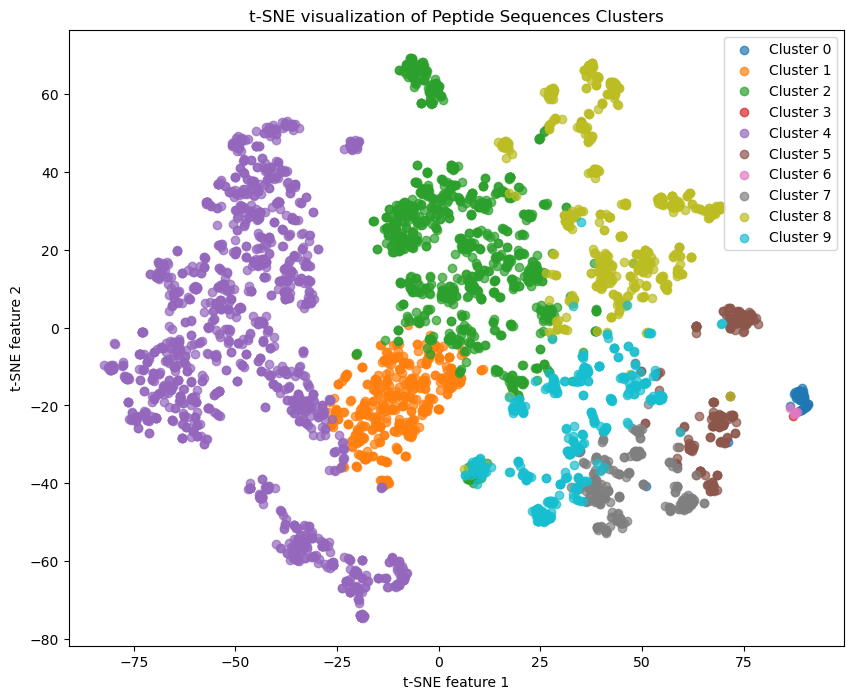

In [52]:
from sklearn.manifold import TSNE

# Reducing the dimensionality for visualization with t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_reduced = tsne.fit_transform(X.toarray())

# Plotting the clusters
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    # Selecting only data points from the current cluster
    indices = clusters == i
    plt.scatter(X_reduced[indices, 0], X_reduced[indices, 1], label=f'Cluster {i}', alpha=0.7)

plt.title("t-SNE visualization of Peptide Sequences Clusters")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.legend()
plt.show()

Clustering based on distance or similarity: local BLAST/K-mer approach

In [59]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import pairwise_distances

In [62]:
from collections import Counter
from sklearn.preprocessing import normalize

def kmer_freq_vector(sequence, k=3):
    """Generate k-mer frequency vector for a given sequence."""
    k_mers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    k_mer_counts = Counter(k_mers)
    total_kmers = sum(k_mer_counts.values())
    return {kmer: count / total_kmers for kmer, count in k_mer_counts.items()}

# Extract sequences
sequences = data['Sequence'].dropna()

# Choose a k-value for k-mer
k = 3

# Create k-mer frequency vectors for each sequence
kmer_vectors = [kmer_freq_vector(seq, k) for seq in sequences]

# Creating a set of all k-mers
all_kmers = set()
for vec in kmer_vectors:
    all_kmers.update(vec.keys())

# Convert k-mer vectors to a matrix
kmer_matrix = np.zeros((len(kmer_vectors), len(all_kmers)))

# Fill the matrix with k-mer frequencies
for i, vec in enumerate(kmer_vectors):
    for j, kmer in enumerate(all_kmers):
        kmer_matrix[i, j] = vec.get(kmer, 0)

# Normalize the matrix
kmer_matrix_normalized = normalize(kmer_matrix, axis=1, norm='l1')

kmer_matrix_normalized.shape, kmer_matrix_normalized[:5]  # Showing the shape and a sample of the matrix


((4455, 7948),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

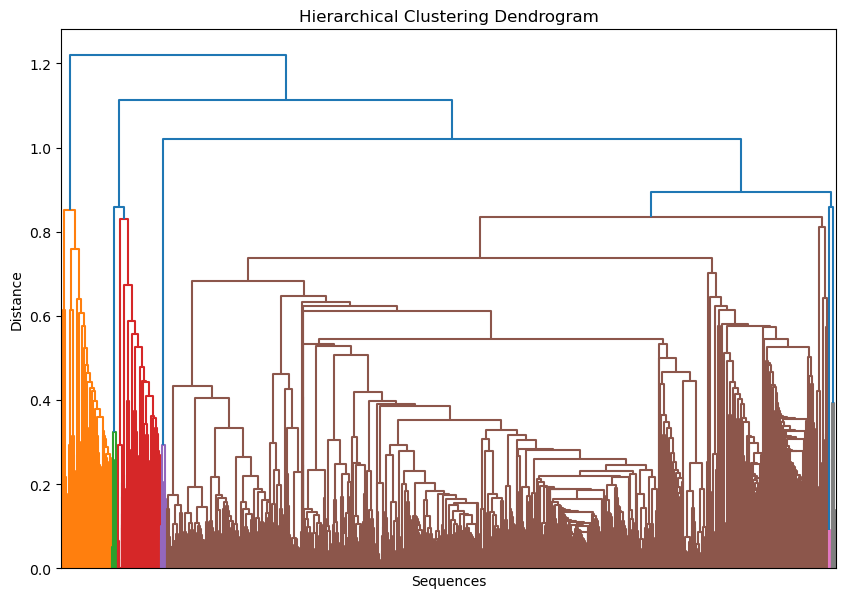

In [63]:
# Perform hierarchical clustering
Z = linkage(kmer_matrix_normalized, method='ward')

# Plotting the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, no_labels=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sequences')
plt.ylabel('Distance')
plt.show()


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4455 samples in 0.048s...
[t-SNE] Computed neighbors for 4455 samples in 2.866s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4455
[t-SNE] Computed conditional probabilities for sample 2000 / 4455
[t-SNE] Computed conditional probabilities for sample 3000 / 4455
[t-SNE] Computed conditional probabilities for sample 4000 / 4455
[t-SNE] Computed conditional probabilities for sample 4455 / 4455
[t-SNE] Mean sigma: 0.020954
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.160873
[t-SNE] KL divergence after 300 iterations: 2.437094


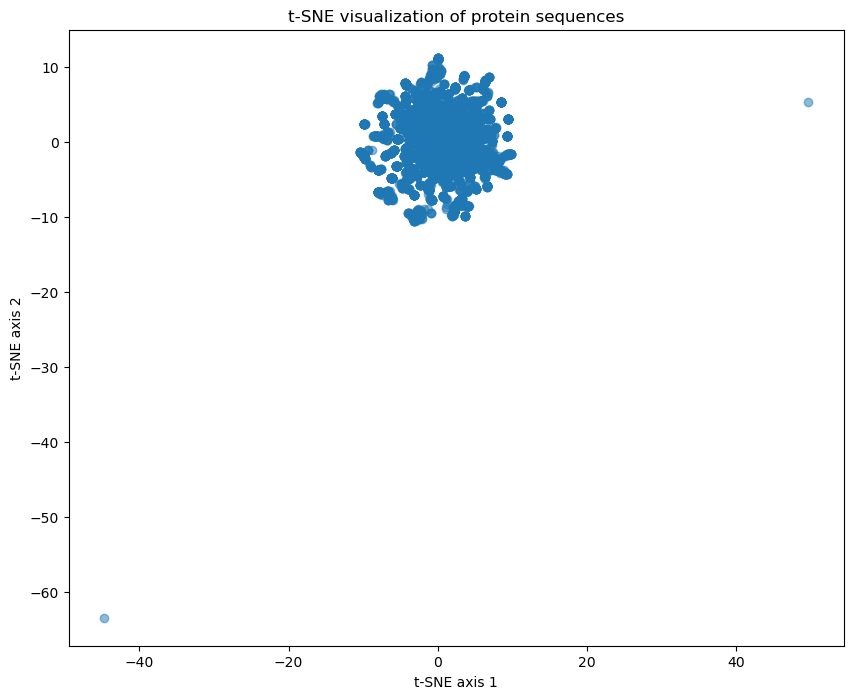

In [64]:
from sklearn.manifold import TSNE

# Applying t-SNE to reduce dimensionality
# Note: t-SNE can be quite slow for large datasets, so we limit the number of iterations and perplexity for speed
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(kmer_matrix_normalized)

# Plotting the results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE visualization of protein sequences')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.show()


Cluster the user inputs

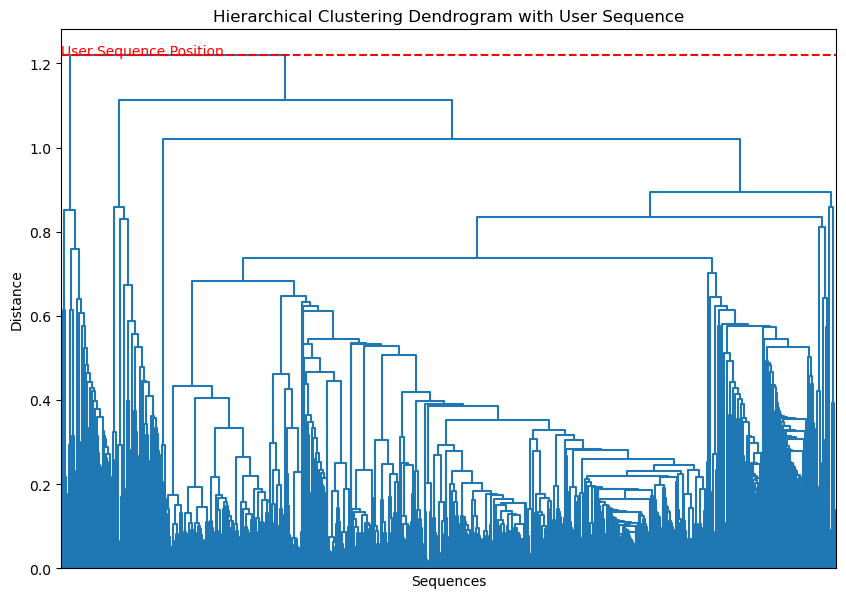

In [65]:
# Convert the user-provided sequence into a k-mer frequency vector
user_sequence = "MSSMLKRNP"
user_kmer_vector = kmer_freq_vector(user_sequence, k)

# Convert the user k-mer vector to the same format as our matrix
user_kmer_array = np.zeros((1, len(all_kmers)))

for j, kmer in enumerate(all_kmers):
    user_kmer_array[0, j] = user_kmer_vector.get(kmer, 0)

# Normalize the user k-mer array
user_kmer_array_normalized = normalize(user_kmer_array, axis=1, norm='l1')

# Append the user sequence to the existing k-mer matrix
extended_kmer_matrix = np.vstack([kmer_matrix_normalized, user_kmer_array_normalized])

# Perform hierarchical clustering on the extended matrix
Z_extended = linkage(extended_kmer_matrix, method='ward')

# Identifying the index of the user's sequence in the dendrogram (it should be the last one)
user_sequence_index = len(Z_extended)

# Plotting the dendrogram with the user's sequence highlighted
plt.figure(figsize=(10, 7))
dendrogram(Z_extended, no_labels=True, color_threshold=0)

# Highlight the user sequence
plt.axhline(y=Z_extended[-1, 2], color='r', linestyle='--')
plt.text(0, Z_extended[-1, 2], 'User Sequence Position', color='red')

plt.title('Hierarchical Clustering Dendrogram with User Sequence')
plt.xlabel('Sequences')
plt.ylabel('Distance')
plt.show()

In [10]:
data.head()

,Unnamed: 0,Entry,SS,Reviewed,Entry Name,Protein names,Gene Names,Organism,Sequence,Binding site,...,Hydrophobic residues,Polar residues,Cystein,Glycin,Absent amino acids,Common amino acids,Aliphatic Index,Instability Index,Coefficient of Extinction,Absorbance 280nm
0,0,D3VML5,AGGIE,reviewed,PZNA_BACVZ,Plantazolicin (PZN) (Plantazolicin A) (Plantaz...,pznA ptnA RBAM_007445,Bacillus velezensis (strain DSM 23117 / BGSC 1...,MTQIKVPTALIASVHGEGQHLFEPMAARCTCTTIISSSSTF,NaN,...,18,19,2,2,DNWY,FHIKLMTV,80.692777,42.275610,250,0.049203
1,1,O07623,AGGIE,reviewed,SBOA_BACSU,Subtilosin-A (Antilisterial bacteriocin subtil...,sboA sbo BSU37350,Bacillus subtilis (strain 168),MKKAVIVENKGCATCSIGAACLVDGPIPDFEIAGATGLFGLWG,NaN,...,23,19,3,7,HQRY,FIKLMTVW,101.028369,20.002326,5875,1.157407
2,2,O31422,AGGIE,reviewed,SKFA_BACSU,Sporulation killing factor (SKF) (Sporulation-...,skfA ybcO BSU01910,Bacillus subtilis (strain 168),MKRNQKEWESVSKKGLMKPGGTSIVKAAGCMGCWASKSIAMTRVCA...,NaN,...,25,22,3,5,DFY,HIKLMTVW,60.811712,25.190909,11375,1.648790
3,3,O34344,AGGIE,reviewed,SDPC_BACSU,Sporulation delaying protein C (SdpC) (Canniba...,sdpC yvaY BSU33770,Bacillus subtilis (strain 168),MKSKLLRLLIVSMVTILVFSLVGLSKESSTSAKENHTFSGEDYFRG...,NaN,...,81,70,2,10,NaN,FHIKLMTVW,92.152840,26.246305,19160,0.741744
4,4,O54329,EXTRA,reviewed,LANA_STRMG,Lantibiotic mutacin-2 (Lantibiotic mutacin H-2...,mutA,Streptococcus mutans,MNKLNSNAVVSLNEVSDSELDTILGGNRWWQGVVPTVSYECRMNSW...,NaN,...,22,17,3,3,NaN,FHIKLMTVW,72.220463,42.779245,18365,2.642826


In [11]:
peptide_sequences[:5]

['MTQIKVPTALIASVHGEGQHLFEPMAARCTCTTIISSSSTF',
 'MKKAVIVENKGCATCSIGAACLVDGPIPDFEIAGATGLFGLWG',
 'MKRNQKEWESVSKKGLMKPGGTSIVKAAGCMGCWASKSIAMTRVCALPHPAMRAI',
 'MKSKLLRLLIVSMVTILVFSLVGLSKESSTSAKENHTFSGEDYFRGLLFGQGEVGKLISNDLDPKLVKEANSTEGKKLVNDVVKFIKKDQPQYMDELKQSIDSKDPKKLIENMTKADQLIQKYAKKNENVKYSSNKVTPSCGLYAVCVAAGYLYVVGVNAVALQTAAAVTTAVWKYVAKYSSSASNNSDLEAAAAKTLKLIHQ',
 'MNKLNSNAVVSLNEVSDSELDTILGGNRWWQGVVPTVSYECRMNSWQHVFTCC']

In [17]:
# Step 1: Tokenize the Peptide Sequences
class AminoAcidTokenizer:
    def __init__(self, sequences):
        self.vocab = self.build_vocab(sequences)

    def build_vocab(self, sequences):
        unique_amino_acids = set(''.join(sequences))
        vocab = {aa: i+1 for i, aa in enumerate(unique_amino_acids)}
        vocab["<PAD>"] = 0
        return vocab

    def encode(self, sequence):
        return [self.vocab.get(aa, 0) for aa in sequence]

tokenizer = AminoAcidTokenizer(peptide_sequences)
encoded_sequences = [tokenizer.encode(seq) for seq in peptide_sequences]

In [18]:
# Step 2: Create a Dataset and DataLoader for Training
class PeptideDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        max_length = max(len(s) for s in self.sequences)
        padded_seq = seq + [0] * (max_length - len(seq))
        return torch.tensor(padded_seq)

peptide_dataset = PeptideDataset(encoded_sequences)
peptide_dataloader = DataLoader(peptide_dataset, batch_size=2, shuffle=True)

In [19]:
# Step 3: Define the Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, hidden_dim, num_layers, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(embed_size, vocab_size)

    def forward(self, src, src_mask):
        src = self.embedding(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

model = TransformerModel(len(tokenizer.vocab), 128, 4, 512, 3, 0.1)

In [30]:
# Adjusting the attention mask creation to match the expected dimensions for multi-head attention

def create_attention_mask(input):
    # Create a mask of 0s and 1s where 0 indicates padding tokens
    mask = (input != 0).unsqueeze(1)
    return mask

num_heads = 8  # Setting the number of heads in the multi-head attention mechanism

def train(model, dataloader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            input = batch.to(torch.int64)
            # Adjusting the mask for padding
            src_mask = create_attention_mask(input)
            output = model(input, src_mask)
            loss = criterion(output.view(-1, vocab_size), input.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch: {epoch}, Loss: {total_loss / len(dataloader)}')


criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Train the model for a few epochs
train(model, peptide_dataloader, optimizer, criterion, epochs=5)


# Train the model for a few epochs
#train(model, peptide_dataloader, optimizer, criterion, epochs=5, num_heads=num_heads)


AssertionError: For batched (3-D) `query`, expected `key_padding_mask` to be `None` or 2-D but found 3-D tensor instead

Simpler LSTM model

In [43]:
# Tokenizer and Dataset
class SimpleTokenizer:
    def __init__(self, sequences):
        unique_amino_acids = set(''.join(sequences))
        self.vocab = {aa: i+1 for i, aa in enumerate(unique_amino_acids)}
        self.vocab["<PAD>"] = 0

    def encode(self, sequence):
        return [self.vocab.get(aa, 0) for aa in sequence]

class PeptideDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        max_length = max(len(s) for s in self.sequences)
        padded_seq = seq + [0] * (max_length - len(seq))  # Padding
        return torch.tensor(padded_seq)

# LSTM Model
class LSTMPeptideModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_dim, num_layers, dropout=0.5):
        super(LSTMPeptideModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out)  # Output for each timestep
        return out

# Training Function
def train_lstm(model, dataloader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            input = batch.to(torch.int64)
            target = torch.roll(input, -1, dims=1)
            output = model(input)
            loss = criterion(output[:, :-1, :].contiguous().view(-1, vocab_size), target[:, :-1].contiguous().view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch: {epoch}, Loss: {total_loss / len(dataloader)}')

# Main Execution
#peptide_sequences = ["your", "peptide", "sequences", "here"]  # Replace with your actual sequences
tokenizer = SimpleTokenizer(peptide_sequences)
encoded_sequences = [tokenizer.encode(seq) for seq in peptide_sequences]

# Truncate sequences and create dataloader
max_seq_length = 100
truncated_sequences = [seq[:max_seq_length] for seq in encoded_sequences]
peptide_dataset = PeptideDataset(truncated_sequences)
peptide_dataloader = DataLoader(peptide_dataset, batch_size=1, shuffle=True)

# Model parameters
vocab_size = len(tokenizer.vocab)
embed_size = 16
hidden_dim = 32
num_layers = 1
dropout = 0.5

# Model, Optimizer, and Criterion
lstm_model = LSTMPeptideModel(vocab_size, embed_size, hidden_dim, num_layers, dropout)
optimizer = Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the model
train_lstm(lstm_model, peptide_dataloader, optimizer, criterion, epochs=15)


Epoch: 0, Loss: 2.464967195373593
Epoch: 1, Loss: 2.36794005349429
Epoch: 2, Loss: 2.316272391066139
Epoch: 3, Loss: 2.278355010116408
Epoch: 4, Loss: 2.2503313524153095
Epoch: 5, Loss: 2.2287042454436974
Epoch: 6, Loss: 2.2108385363746303
Epoch: 7, Loss: 2.1959670860826233
Epoch: 8, Loss: 2.1829772686784383
Epoch: 9, Loss: 2.1726501766345585
Epoch: 10, Loss: 2.163704105338665
Epoch: 11, Loss: 2.155163230371529
Epoch: 12, Loss: 2.1474545275322114
Epoch: 13, Loss: 2.140731003094469
Epoch: 14, Loss: 2.1390335167163417


Using LSTM but with train test split and CV

In [69]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from sklearn.model_selection import train_test_split

# Tokenizer Class
class SimpleTokenizer:
    def __init__(self, sequences):
        unique_amino_acids = set(''.join(sequences))
        self.vocab = {aa: i+1 for i, aa in enumerate(unique_amino_acids)}
        self.vocab["<PAD>"] = 0

    def encode(self, sequence):
        return [self.vocab.get(aa, 0) for aa in sequence]

# Dataset Class
class PeptideDataset(Dataset):
    def __init__(self, sequences, max_length):
        self.sequences = sequences
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        padded_seq = seq + [0] * (self.max_length - len(seq))  # Padding
        return torch.tensor(padded_seq)

# LSTM Model
class LSTMPeptideModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_dim, num_layers, dropout=0.5):
        super(LSTMPeptideModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out)  # Output for each timestep
        return out

# Training and Validation Function
def train_and_validate_lstm(model, train_loader, test_loader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input = batch.to(torch.int64)
            target = torch.roll(input, -1, dims=1)
            output = model(input)
            loss = criterion(output[:, :-1, :].contiguous().view(-1, vocab_size), target[:, :-1].contiguous().view(-1))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                input = batch.to(torch.int64)
                target = torch.roll(input, -1, dims=1)
                output = model(input)
                loss = criterion(output[:, :-1, :].contiguous().view(-1, vocab_size), target[:, :-1].contiguous().view(-1))
                total_val_loss += loss.item()

        print(f'Epoch: {epoch}, Train Loss: {total_train_loss / len(train_loader)}, Validation Loss: {total_val_loss / len(test_loader)}')

# Main Execution
# Assuming peptide_sequences is a list of your sequences
tokenizer = SimpleTokenizer(peptide_sequences)
encoded_sequences = [tokenizer.encode(seq) for seq in peptide_sequences]

# Determine maximum sequence length
max_seq_length = max(len(seq) for seq in encoded_sequences)

# Split data into training and testing
train_seqs, test_seqs = train_test_split(encoded_sequences, test_size=0.2, random_state=42)

# Create datasets and dataloaders for both training and testing
train_dataset = PeptideDataset(train_seqs, max_seq_length)
test_dataset = PeptideDataset(test_seqs, max_seq_length)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Model parameters
vocab_size = len(tokenizer.vocab)
embed_size = 16
hidden_dim = 32
num_layers = 1
dropout = 0.5

# Model, Optimizer, and Criterion
lstm_model = LSTMPeptideModel(vocab_size, embed_size, hidden_dim, num_layers, dropout)
optimizer = Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the model
train_and_validate_lstm(lstm_model, train_dataloader, test_dataloader, optimizer, criterion, epochs=15)


c:\Users\aubhi\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, Train Loss: 0.2629042748637773, Validation Loss: 0.214706777924914
Epoch: 1, Train Loss: 0.20828150060366502, Validation Loss: 0.21137154349564438
Epoch: 2, Train Loss: 0.20541424782869358, Validation Loss: 0.2085441594041316
Epoch: 3, Train Loss: 0.20237510532399955, Validation Loss: 0.20526835277693287
Epoch: 4, Train Loss: 0.19930958383174155, Validation Loss: 0.2026731879178919
Epoch: 5, Train Loss: 0.1965651248370566, Validation Loss: 0.19994891415696775
Epoch: 6, Train Loss: 0.1943985116735987, Validation Loss: 0.19826160980213117
Epoch: 7, Train Loss: 0.19270478311495481, Validation Loss: 0.19655825602801125
Epoch: 8, Train Loss: 0.19116397767027737, Validation Loss: 0.1952761250627415
Epoch: 9, Train Loss: 0.18993004718136908, Validation Loss: 0.19413374355605767
Epoch: 10, Train Loss: 0.1888091300335095, Validation Loss: 0.1935443160261942
Epoch: 11, Train Loss: 0.1879498572407581, Validation Loss: 0.19264346272621988
Epoch: 12, Train Loss: 0.18746010370565083, Valid

In [70]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate(model, test_loader, criterion):
    model.eval()
    all_predictions = []
    all_targets = []

    total_val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            input = batch.to(torch.int64)
            target = torch.roll(input, -1, dims=1)
            output = model(input)

            # Compute loss
            loss = criterion(output[:, :-1, :].contiguous().view(-1, vocab_size), target[:, :-1].contiguous().view(-1))
            total_val_loss += loss.item()

            # Convert output probabilities to predicted class (argmax over vocabulary)
            preds = torch.argmax(output, dim=-1)
            all_predictions.extend(preds.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_predictions, average='macro')
    
    return total_val_loss / len(test_loader), accuracy, precision, recall, f1


c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0, Train Loss: 0.18470844523050936, Validation Loss: 0.1898267271139162, Accuracy: 0.9422720860724753, Precision: 0.32774398615922223, Recall: 0.23136017931808076, F1: 0.24064381478646127


c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1, Train Loss: 0.18405833797305654, Validation Loss: 0.18882750823776417, Accuracy: 0.9424728706769296, Precision: 0.33779837852817224, Recall: 0.23224913022841623, F1: 0.24070265075966624


c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2, Train Loss: 0.18359998041423148, Validation Loss: 0.1882879813222607, Accuracy: 0.9427307548658674, Precision: 0.3326489330749285, Recall: 0.237026591462011, F1: 0.24564714930716403


c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3, Train Loss: 0.18341339754900246, Validation Loss: 0.18788907045473432, Accuracy: 0.9428210845364029, Precision: 0.3367504535334272, Recall: 0.23770495788454069, F1: 0.24755401431699456


c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4, Train Loss: 0.18328392970470836, Validation Loss: 0.1876494939368001, Accuracy: 0.942828104977118, Precision: 0.32669818140231816, Recall: 0.2379511393853564, F1: 0.24675126030669373


c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5, Train Loss: 0.182678158037515, Validation Loss: 0.1883070114582376, Accuracy: 0.9426062590505182, Precision: 0.3237180629380249, Recall: 0.23670305835150965, F1: 0.2444240005971287


c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6, Train Loss: 0.18250391877221842, Validation Loss: 0.18744413692069828, Accuracy: 0.9428678874745041, Precision: 0.3254803786268319, Recall: 0.2402296641601944, F1: 0.24920948743740753


c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7, Train Loss: 0.18697092975317328, Validation Loss: 0.19175979238203955, Accuracy: 0.941472223860325, Precision: 0.32008995929310147, Recall: 0.21912000959210542, F1: 0.22897910956747286


c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8, Train Loss: 0.18328423327196694, Validation Loss: 0.18697649167407923, Accuracy: 0.9430918395333185, Precision: 0.33806929874462727, Recall: 0.24035013638166988, F1: 0.24982129173786768


c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9, Train Loss: 0.18173347876901613, Validation Loss: 0.18670370081447968, Accuracy: 0.9431016681503198, Precision: 0.32900886000327634, Recall: 0.24265357922754419, F1: 0.2512192354258401


c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 10, Train Loss: 0.18158724681630012, Validation Loss: 0.18637683836434188, Accuracy: 0.9432624362426976, Precision: 0.34033953190355765, Recall: 0.2423255303550258, F1: 0.2516966489999125


c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 11, Train Loss: 0.18151195255431163, Validation Loss: 0.1862581567462918, Accuracy: 0.9432900499761773, Precision: 0.3474957706048217, Recall: 0.24118617987878616, F1: 0.25145304854405864


c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 12, Train Loss: 0.18315836267209248, Validation Loss: 0.1867433246517462, Accuracy: 0.9431243675752989, Precision: 0.34230004231400646, Recall: 0.23847720290933186, F1: 0.24960875547871655


c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 13, Train Loss: 0.1808625777094185, Validation Loss: 0.1856541199392468, Accuracy: 0.9434852182280595, Precision: 0.33965158591353345, Recall: 0.24510695842721084, F1: 0.25592016576745286


c:\Users\aubhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 14, Train Loss: 0.18128684749272803, Validation Loss: 0.1858280665980393, Accuracy: 0.9434026110423108, Precision: 0.3350870534184114, Recall: 0.24695151762493397, F1: 0.2563049195131705


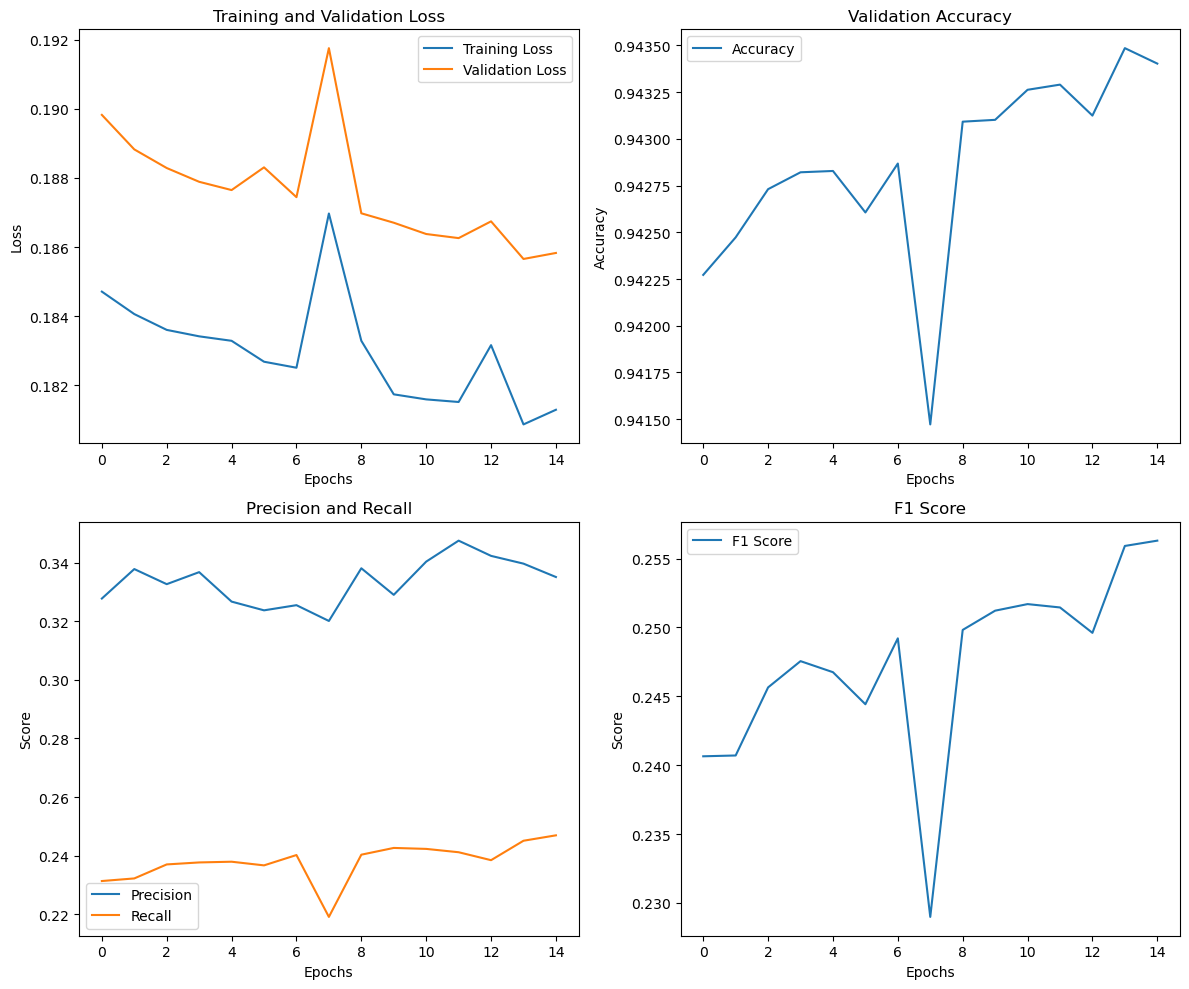

In [79]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Tokenizer, Dataset, and LSTM Model definitions go here
# ...

# Training and Validation Function
def train_and_validate_lstm(model, train_loader, test_loader, optimizer, criterion, epochs):
    train_losses = []
    val_losses = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input = batch.to(torch.int64)
            target = torch.roll(input, -1, dims=1)
            output = model(input)
            loss = criterion(output[:, :-1, :].contiguous().view(-1, vocab_size), target[:, :-1].contiguous().view(-1))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(train_loader))

        # Validation
        model.eval()
        all_predictions = []
        all_targets = []
        total_val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                input = batch.to(torch.int64)
                target = torch.roll(input, -1, dims=1)
                output = model(input)
                loss = criterion(output[:, :-1, :].contiguous().view(-1, vocab_size), target[:, :-1].contiguous().view(-1))
                total_val_loss += loss.item()

                # Convert output probabilities to predicted class (argmax over vocabulary)
                preds = torch.argmax(output, dim=-1)
                all_predictions.extend(preds.view(-1).cpu().numpy())
                all_targets.extend(target.view(-1).cpu().numpy())

        val_losses.append(total_val_loss / len(test_loader))

        # Calculate metrics
        accuracy = accuracy_score(all_targets, all_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_predictions, average='macro')
        
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        print(f'Epoch: {epoch}, Train Loss: {total_train_loss / len(train_loader)}, Validation Loss: {total_val_loss / len(test_loader)}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}')

    # Plotting
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(accuracies, label='Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(precisions, label='Precision')
    plt.plot(recalls, label='Recall')
    plt.title('Precision and Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(f1_scores, label='F1 Score')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Tokenizer, Dataset, DataLoader, Model, Optimizer, Criterion initialization
# ...

# Train the model
train_and_validate_lstm(lstm_model, train_dataloader, test_dataloader, optimizer, criterion, epochs=15)


Using gpt2

In [44]:
from transformers import GPT2Tokenizer
from torch.utils.data import Dataset, DataLoader
import torch

# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# Set the padding token
tokenizer.pad_token = tokenizer.eos_token

class TextDataset(Dataset):
    def __init__(self, texts):
        self.encodings = tokenizer(texts, truncation=True, padding=True)

    def __len__(self):
        return len(self.encodings.input_ids)

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

# Example text data
#texts = ["Hello, how are you?", "I am fine.", "Here is some sample text data."]
texts = peptide_sequences
dataset = TextDataset(texts)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


In [45]:
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, hidden_dim, num_layers, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(embed_size, vocab_size)

    def forward(self, src, src_mask):
        src = self.embedding(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

# Model parameters
vocab_size = tokenizer.vocab_size
embed_size = 256
num_heads = 8
hidden_dim = 512
num_layers = 4
dropout = 0.1

model = TransformerModel(vocab_size, embed_size, num_heads, hidden_dim, num_layers, dropout)


Epoch: 0, Loss: 0.5598
Epoch: 1, Loss: 0.4694
Epoch: 2, Loss: 0.4828
Epoch: 3, Loss: 0.4260
Epoch: 4, Loss: 0.3973
Epoch: 5, Loss: 0.3851
Epoch: 6, Loss: 0.3734
Epoch: 7, Loss: 0.3579
Epoch: 8, Loss: 0.3449
Epoch: 9, Loss: 0.3115


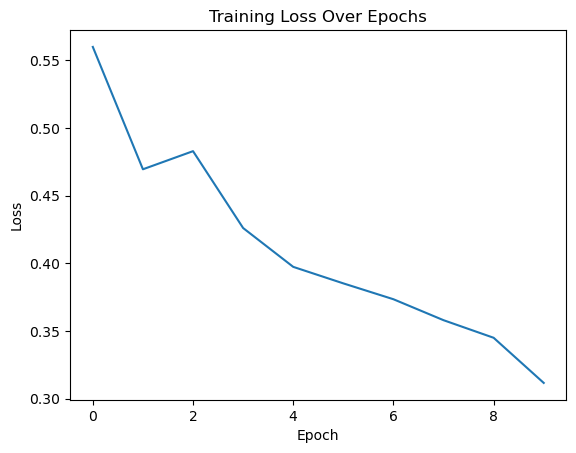

In [66]:
from torch.optim import Adam

def generate_square_subsequent_mask(size):
    mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train(dataloader):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = generate_square_subsequent_mask(input_ids.size(0)).to(device)
        
        output = model(input_ids, attention_mask)
        loss = criterion(output.view(-1, vocab_size), input_ids.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

losses = []
# Training the model
for epoch in range(10): # number of epochs
    loss = train(dataloader)
    losses.append(loss)
    print(f"Epoch: {epoch}, Loss: {loss:.4f}")
    
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


It will be parallized using AWS cloud (22 hrs in mononode); note: This code is not tested or validated; but can be used for classification, recommendation and autofilling peptides

In [ ]:
import torch

# Example peptide sequence
peptide_sequence = "MSPPRNKFFA"

# Tokenize the sequence
input_ids = tokenizer.encode(peptide_sequence)
input_ids = torch.tensor([input_ids])  # Convert to a PyTorch tensor

# Generate attention mask (if your model requires it)
#attention_mask = generate_square_subsequent_mask(input_ids.size(1)).to(device)

# Now you can feed it into the model
model.eval()
with torch.no_grad():
    outputs = model(input_ids.to(device), attention_mask=attention_mask, output_attentions=True)
    attentions = outputs.attentions
    # Analyze these attention weights


In [75]:
"""def test(dataloader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No gradients needed for testing
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = generate_square_subsequent_mask(input_ids.size(0)).to(device)

            output = model(input_ids, attention_mask)
            loss = criterion(output.view(-1, vocab_size), input_ids.view(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

test_loss = test(test_dataloader)
print(f"Test Loss: {test_loss:.4f}")"""

"""from sklearn.metrics import confusion_matrix
import torch

def get_predictions_and_labels(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():  # No gradients needed for prediction
        for batch in dataloader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)  # Adjust depending on your dataloader format

            # Assuming your model returns logits
            outputs = model(inputs)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs

            # Convert logits to predictions
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels




# a function to get predictions and true labels
predictions, true_labels = get_predictions_and_labels(model, dataloader)

conf_mat = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_mat, annot=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
"""

'''from sklearn.manifold import TSNE

# Extract embeddings from the model (this depends on your model's architecture)
embeddings = model.embedding.weight.cpu().detach().numpy()

tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.show()
'''

'''# This requires custom implementation to extract attention weights from the model
attention_weights = get_attention_weights(model, input_sequence)

sns.heatmap(attention_weights)
plt.xlabel('Sequence Position')
plt.ylabel('Attention Weight')
plt.show()
'''



"# This requires custom implementation to extract attention weights from the model\nattention_weights = get_attention_weights(model, input_sequence)\n\nsns.heatmap(attention_weights)\nplt.xlabel('Sequence Position')\nplt.ylabel('Attention Weight')\nplt.show()\n"

Recommendations for completion of sequences based on initial user input 

In [ ]:
def generate_sequence(model, seed_sequence, max_length):
    model.eval()  # Set the model to evaluation mode
    
    # Tokenize the seed sequence
    input_ids = tokenizer.encode(seed_sequence)

    for _ in range(max_length):
        # Convert to tensor and add batch dimension
        inputs = torch.tensor([input_ids], device=device)
        
        # Generate mask for the inputs
        attention_mask = generate_square_subsequent_mask(inputs.size(1)).to(device)

        # Get model output
        with torch.no_grad():
            output = model(inputs, attention_mask)

        # Select the token with the highest probability from the last position
        next_token_id = output[0, -1].argmax().item()
        input_ids.append(next_token_id)

        # (Optional) Stop if an end-of-sequence token is generated

    # Decode the generated sequence back to text (amino acids)
    generated_sequence = tokenizer.decode(input_ids)
    return generated_sequence

# Generate a sequence using the trained model
seed_sequence = "Your seed sequence here"
generated_sequence = generate_sequence(model, seed_sequence, max_length=50)
print("Generated Sequence:", generated_sequence)
